## RODRIGUEZ FRANCK & CERCELET MATTHIAS

Dans cette partie nous allons nous intéresser à la partie $\textit{Transfer Learning}$ et $\textit{Finetuning}$. Dans la première partie qui correspond au projet Machine Learning, nous avons vu comment le modèle de prédictions d'ECG fonctionne, comment celui-ci prédit les maladies, avec quel pourcentage de prédiction etc.
Nous allons donc dans cette partie, utiliser ce modèle vu précedemment et le modifier de manière à y appliquer notre nouveau dataset.

Les commandes ci-dessous vont nous permettre de générer notre dataset, et de voir à quoi celui-ci ressemble. 

Malheureusement, nous n'avons pu prendre qu'une partie de notre target, car la puissance de l'ordinateur ainsi que de google colab ne nous permettent pas de pouvoir prendre l'entièretée de ce dataset.

## 1. Convert raw datasets from hospital centers into usable variables to train our model
### a. Import required libraries
    

In [1]:
import pandas as pd
import numpy as np
import wfdb
import ast #package typed-ast
import tensorflow.keras
import scikitplot as skplt
import os

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#Print versions
print('pandas version is :', pd.__version__)
print('numpy version is :', np.__version__)
print('wfdb version is :', wfdb.__version__)

pandas version is : 1.3.4
numpy version is : 1.19.5
wfdb version is : 3.4.1


In [2]:
from platform import python_version

print(python_version())

3.7.11


### b. Get the data to prepare the training phase



In [3]:
from tqdm import tqdm
def load_raw_data(df, sampling_rate, path):
    data = []
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        i=0
        for f in tqdm(df.filename_hr):
            data.append(wfdb.rdsamp(path+f))
            i+=1

    data = np.array([signal for signal, meta in data])
    return data

path = os.path.expanduser('~/Desktop/ML/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/')  #SET YOUR DIRECTORY HERE!!!
#path = '/Users/lrisser/Taff/2021_NNetECG/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/'
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y = Y[0:5000] # l'on prend seulement 5000 Y


# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)
#X = load_raw_data(Y[0:1000], sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
#Y = Y[0:1000]

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

100%|██████████████████████████████████████| 5000/5000 [00:29<00:00, 166.87it/s]


In [4]:
def delete_unk_ecg(x,y):
    y = list(y)
    x_processed,y_processed = [],[]
    for index,dis in enumerate(y):
        if dis != []:
            x_processed.append(x[index])
            y_processed.append(y[index])
    return x_processed,y_processed


X_train,y_train = delete_unk_ecg(X_train,y_train)
X_test,y_test = delete_unk_ecg(X_test,y_test)
            
y_train = np.array(y_train,dtype=object)
y_test = np.array(y_test,dtype=object)
X_train = np.array(X_train)
X_test = np.array(X_test)

In [5]:
print("La taille de notre X_train :" X_train.shape)
print("La taille de notre y_train :" y_train.shape)
print("La taille de notre X_test :" X_test.shape)
print("La taille de notre y_test :" y_test.shape)

(4327,)
(4327, 5000, 12)
(615, 5000, 12)
(615,)


###    c. Convert the y_train into a usable format  
    

In [6]:
#Define the diseases
diseases = ["NORM","MI","HYP","CD","STTC"] # ce sont les différentes maladies

#Create a RIBEIRO format training data
def Ribeiro_convert(y_train):
    
    y_train = list(y_train)

    y_train_ = [[0,0,0,0] for i in list(y_train)]
    for index, info in enumerate(y_train):

        for disease in info:

            if disease != 'NORM':
                y_train_[index][diseases.index(disease)-1] = 1

    y_train_ = np.array(y_train_)
    return y_train_

y_train = Ribeiro_convert(y_train)
y_test = Ribeiro_convert(y_test)

print(y_train.shape)
print(y_test.shape)

##Reformat the ECG aquisition, 4048 samples needed.

(4327, 4)
(615, 4)


### d. Rescale the data
    Ribeiro is adaptated to 400Hz/10sec : 4096 samples, on this dataset the ECG are converted into 5000 samples array, we have to interpolate and convert array with shape (5000,) into (4096,)
    

In [7]:
import cv2 # opencv
from tqdm import tqdm

def convert_X(X,scale):
    X_conv = np.empty((X.shape[0], 4096, 12))
    for index,array in enumerate(X):
        array = cv2.resize(array,(12,scale))
        X_conv[index,:,:]=array
    return X_conv
    
X_train_=convert_X(X_train,4096)    
X_test_=convert_X(X_test,4096)    

print(X_train.shape)
print(X_train_.shape)
print(X_test.shape)
print(X_test_.shape)

(4327, 5000, 12)
(4327, 4096, 12)
(615, 5000, 12)
(615, 4096, 12)


#### check the interpolation

y= [1 0 0 0]
Disease = MI


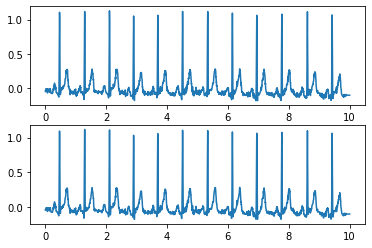

In [8]:
import numpy as np
import matplotlib.pyplot as plt

y = np.linspace(0,10,5000)
y_ =np.linspace(0,10,4096)

ObsID=7     #you can change the obsevations here
ChannelID=0 #you can change the channel here

plt.subplot(2, 1, 1)
plt.plot(y,X_train[ObsID,:,ChannelID])
plt.subplot(2, 1, 2)
plt.plot(y_,X_train_[ObsID,:,ChannelID])

print('y=',y_train[ObsID])

if (y_train[ObsID][0]==1):
    print("Disease = MI")
elif (y_train[ObsID][1]==1):
    print("Disease = HYP")
elif (y_train[ObsID][2]==1):
    print("Disease = CD")
elif (y_train[ObsID][3]==1):
    print("Disease = STTC")

Dans le code ci-dessus, nous avons seulement $4$ maladies que sont : $MI$, $HYP$, $CD$ et $STTC$. Tandis que dans le modèle nous avons $6$ maladies en sorties. C'est donc la raison pour laquelle nous allons devoir modifier le modèle. Il ne nous faudra changer que quelques couches pour pouvoir applique le modèle à ce nouveau dataset.

## Modification du modèle

### Transfer Learning 
Ici nous allons geler tout le modèle, en gardant les paramètres qu'il a acquis durant l'entrainement. Puis nous allons supprimer la dernière couche et la remplacer par d'autres pour pouvoir y appliquer notre dataset.


Dans le code ci-dessous, nous reprenons le modèle `model.hdf5` qui est le modèle de prédiction des maladies. 

In [10]:
import argparse
#warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from datasets import ECGSequence

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='Get performance on test set from hdf5')
    parser.add_argument('path_to_hdf5', type=str,
                        help='path to hdf5 file containing tracings')
    parser.add_argument('path_to_model',  # or model_date_order.hdf5
                        help='file containing training model.')
    parser.add_argument('--dataset_name', type=str, default='tracings',
                        help='name of the hdf5 dataset containing tracings')
    parser.add_argument('--output_file', default="./dnn_output2.npy",  # or predictions_date_order.csv
                        help='output csv file.')
    parser.add_argument('-bs', type=int, default=32,
                        help='Batch size.')

    args, unk = parser.parse_known_args(['data/ecg_tracings.hdf5','model/model.hdf5'])
    if unk:
        warnings.warn("Unknown arguments:" + str(unk) + ".")

    # Import data
    seq = ECGSequence(args.path_to_hdf5, args.dataset_name, batch_size=args.bs)
    #Import model
    model = load_model(args.path_to_model, compile=False)

2022-02-27 18:17:36.112162: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
new_model.summary()

In [11]:
model.trainable = False

La commande ci-dessus nous permet de geler toutes les couches du modèle en gardant les paramètres de chaque couche.

In [12]:
model_output = [layer.output for layer in model.layers[:-1]]
new_end = Dense(4096, activation = 'relu')(model_output[-1])
new_end = Dense(4096, activation = 'relu')(new_end)
new_end = Dense(4, activation = 'sigmoid')(new_end)
new_model = tensorflow.keras.Model(inputs = model.input, outputs = new_end)

La dernière couche ajouté est une couche `Dense` de taille $4$ car c'est le nombre de variables qu'il y aura en sorties. Nous avons également ajouté $2$ couches `Dense` de taille $4096$ car nous avons décidé de prendre exemple sur le modèle $VGG16$.

In [13]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             [(None, 4096, 12)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4096, 64)     12288       signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4096, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 4096, 64)     0           batch_normalization_1[0][0]      
______________________________________________________________________________________________

In [14]:
new_model.compile(loss = 'binary_crossentropy', optimizer = Adam())
new_model.fit(X_train_, y_train, batch_size = 128, epochs = 15, validation_split = 0.2)

2022-02-27 18:17:51.432802: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12
28/28 [==============================] - 224s 8s/step - loss: 0.4650 - val_loss: 0.4778
Epoch 2/12
28/28 [==============================] - 178s 6s/step - loss: 0.4190 - val_loss: 0.4412
Epoch 3/12
28/28 [==============================] - 174s 6s/step - loss: 0.4072 - val_loss: 0.4331
Epoch 4/12
28/28 [==============================] - 155s 6s/step - loss: 0.4001 - val_loss: 0.4473
Epoch 5/12
28/28 [==============================] - 153s 6s/step - loss: 0.3933 - val_loss: 0.4282
Epoch 6/12
28/28 [==============================] - 154s 6s/step - loss: 0.3956 - val_loss: 0.4353
Epoch 7/12
28/28 [==============================] - 153s 5s/step - loss: 0.3938 - val_loss: 0.4215
Epoch 8/12
28/28 [==============================] - 154s 6s/step - loss: 0.3923 - val_loss: 0.4212
Epoch 9/12
28/28 [==============================] - 155s 6s/step - loss: 0.3941 - val_loss: 0.4224
Epoch 10/12
28/28 [==============================] - 153s 6s/step - loss: 0.3861 - val_loss: 0.4301
Epoch 11/

Pour l'entrainement de notre modèle, nous gardons une validation_split de $0.2$ qui reste un bon compromis quelque soit le modèle. Nous avons par contre choisit d'entrainer notre modèle sur $15$ epochs et sur un batch_size de $128$ car nous mettrions encore plus de temps à entrainer notre modèle.

In [15]:
df_predicts = new_model.predict(X_test_)
df_predicts = np.round(df_predicts)
df_predicts = pd.DataFrame(data = df_predicts, columns = ["MI","HYP","CD","STTC"])
df_predicts.to_csv('Pred_Transfer_Learning.csv')

Ici nous exportons nos prédictions vers un fichier csv pour pouvoir ensuite les utilisées pour de la comparaison et plus simplement pour les examiner.

In [16]:
df_test = pd.DataFrame(data = y_test, columns = ["MI","HYP","CD","STTC"])

Dans les lignes de codes qui sont en dessous, nous allons afficher la matrice de confusion, la courbe ROC ainsi que les pourcentages de bonnes prédictions. 

In [17]:
y_true1 = np.asarray(df_test["MI"])
data_pred1 = np.asarray(df_predicts["MI"])
y_score1 = np.asarray([1-data_pred1,data_pred1]).T

y_true2 = np.asarray(df_test["HYP"])
data_pred2 = np.asarray(df_predicts["HYP"])
y_score2 = np.asarray([1-data_pred2,data_pred2]).T

y_true3 = np.asarray(df_test["CD"])
data_pred3 = np.asarray(df_predicts["CD"])
y_score3 = np.asarray([1-data_pred3,data_pred3]).T

y_true4 = np.asarray(df_test["STTC"])
data_pred4 = np.asarray(df_predicts["STTC"])
y_score4 = np.asarray([1-data_pred4,data_pred4]).T

#### Prédiction de la maladie MI :

In [28]:
cm = confusion_matrix(df_predicts["MI"], df_test["MI"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour MI :", accuracy_score(df_predicts["MI"], df_test["MI"])*100)

print("La precision du modèle est : ", cm[0,0]/(cm[0,0]+cm[0,1]))
print("Le recall du modèle est :", cm[0,0]/(cm[0,0]+cm[1,0]))

Matrice de confusion [[474 113]
 [ 13  15]]
Pourcentage d'erreur 20.48780487804878
Score pour MI : 79.51219512195122
La precision du modèle est :  0.807495741056218
Le recall du modèle est : 0.973305954825462


On rappelle que la précision est définit comme suivant : la précision (ou valeur prédictive positive) est la proportion des items pertinents parmi l'ensemble des items proposés.
On rappelle également que le rappel est définit comme suivant : le rappel (ou sensibilité) est la proportion des items pertinents proposés parmi l'ensemble des items pertinents.

Nous cherchons à avoir les trois valeurs que sont la precision, le recall et l'accuracy tout trois à $100$. Dans la prédictino de cette maladie, nous avons des scores assez élevés. Toutefois, l'accuracy est assez faible pour avoir une bonne prédiction, il nous faudrait un minimum de $92$-$93\%$. Seulement le recall est assez bon ici, il faudrait également avoir un meilleur résultat pour la precision.

L'aire sous la courbe est égale à  0.5452467274127311


/Users/MatthiasCercelet/opt/anaconda3/envs/tfenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


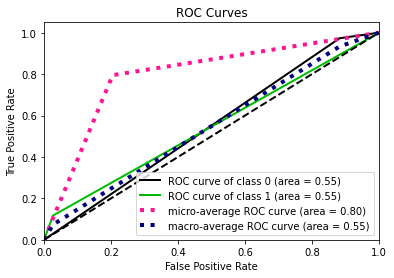

In [19]:
skplt.metrics.plot_roc_curve(y_true1,y_score1)
#print(np.shape(y_true1),np.shape(np.asarray([data_pred1]).T))
print("L'aire sous la courbe est égale à ",roc_auc_score(y_true1,np.asarray([data_pred1]).T))

La courbe ROC conforte les résultats que nous avons annoncé précédemment.

#### Prediction de la maladie HYP :

In [29]:
cm = confusion_matrix(df_predicts["HYP"], df_test["HYP"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour HYP :", accuracy_score(df_predicts["HYP"], df_test["HYP"])*100)

print("La precision du modèle est : ", cm[0,0]/(cm[0,0]+cm[0,1]))
print("Le rappel du modèle est :", cm[0,0]/(cm[0,0]+cm[1,0]))

Matrice de confusion [[544  71]
 [  0   0]]
Pourcentage d'erreur 11.544715447154472
Score pour HYP : 88.45528455284553
La precision du modèle est :  0.8845528455284553
Le recall du modèle est : 1.0


La prédiction du modèle dans le cas de cette maladie-ci est nettement meilleure que pour la maladie précédente.nIci le score est de $89\%$ tout comme la précision du modèle. On a également un recall de $1$, ce qui est parfait. Cela est notamment du au fait que le nombre de faux négatifs est de $0$.

/Users/MatthiasCercelet/opt/anaconda3/envs/tfenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


L'aire sous la courbe est égale à  0.5


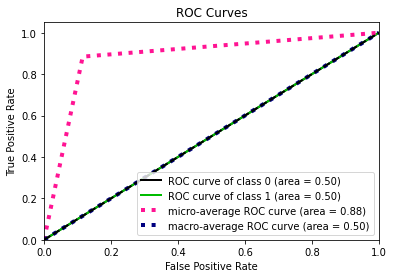

In [21]:
skplt.metrics.plot_roc_curve(y_true2,y_score2)
#print(np.shape(y_true1),np.shape(np.asarray([data_pred1]).T))
print("L'aire sous la courbe est égale à ",roc_auc_score(y_true2,np.asarray([data_pred2]).T))

#### Prediction de la maladie CD :

In [30]:
cm = confusion_matrix(df_predicts["CD"], df_test["CD"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour CD :", accuracy_score(df_predicts["CD"], df_test["CD"])*100)

print("La precision du modèle est : ", cm[0,0]/(cm[0,0]+cm[0,1]))
print("Le recall du modèle est :", cm[0,0]/(cm[0,0]+cm[1,0]))

Matrice de confusion [[485  70]
 [ 14  46]]
Pourcentage d'erreur 13.658536585365855
Score pour CD : 86.34146341463415
La precision du modèle est :  0.8738738738738738
Le recall du modèle est : 0.9719438877755511


La prédiction du modèle dans le cas de cette maladie-ci est également bonne. Celle-ci est moins bonne que la précédente mais rest néanmoins intéressante par rapport à la première.

L'aire sous la courbe est égale à  0.6842478059567411


/Users/MatthiasCercelet/opt/anaconda3/envs/tfenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


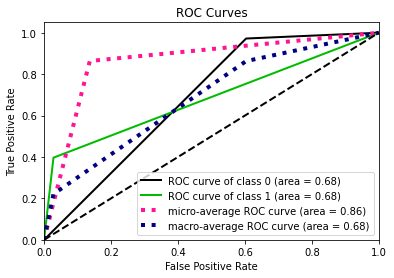

In [23]:
skplt.metrics.plot_roc_curve(y_true3,y_score3)
#print(np.shape(y_true1),np.shape(np.asarray([data_pred1]).T))
print("L'aire sous la courbe est égale à ",roc_auc_score(y_true3,np.asarray([data_pred3]).T))

#### Prediction de la maladie STTC :

In [31]:
cm = confusion_matrix(df_predicts["STTC"], df_test["STTC"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("score du dnn pour STTC :", accuracy_score(df_predicts["STTC"], df_test["STTC"])*100)

print("La precision du modèle est : ", cm[0,0]/(cm[0,0]+cm[0,1]))
print("Le recall du modèle est :", cm[0,0]/(cm[0,0]+cm[1,0]))

Matrice de confusion [[462 122]
 [ 13  18]]
Pourcentage d'erreur 21.951219512195124
score du dnn pour STTC : 78.04878048780488
La precision du modèle est :  0.791095890410959
Le recall du modèle est : 0.9726315789473684


Dans ce cas-ci, les prédictions restent correctes mais semble être moins intéressantes que pour les deux maladies précédentes.

L'aire sous la courbe est égale à  0.5506015037593985


/Users/MatthiasCercelet/opt/anaconda3/envs/tfenv/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


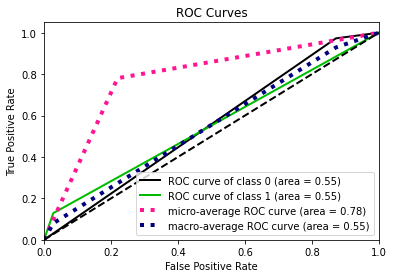

In [25]:
skplt.metrics.plot_roc_curve(y_true4,y_score4)
#print(np.shape(y_true1),np.shape(np.asarray([data_pred1]).T))
print("L'aire sous la courbe est égale à ",roc_auc_score(y_true4,np.asarray([data_pred4]).T))

Ci nous devions faire un résumé de tout ce qui a été fait et vu dans cette partie. Nous pourrions partir du constat que le *Transfer Learning* peut être une pratique très intéréssante, car cela nous évite de devoir créer un modèle en partant de zéro, ce qui peut parfois être très compliqué suivant le dataset comme c'est le cas ici. Cela nous fait gagner beaucoup de temps dans la recherche d'un modèle dit "parfait" pour notre dataset. Dans l'ensemble il nous suffit juste de remplacer les dernières couches, en gelant toutes les autres. On peut plus ou moins remonter de manière inverse dans le modèle pour obtenir un modèle qui concorde mieux à notre dataset. Cependant, plus on dégèle de couches et plus nous allons mettre du temps à entrainer le modèle. Il faut donc trouver le bon compromis entre les deux.

Pour ce qui est de la bonne prédiction du modèle pour le nouveau dataset, nous avons vu que suivant les maladies, le modèle est plus ou moins bon. Dans l'ensemble c'est un bon modèle. Malheureusement, si l'on compare les résultats du modèle sur l'ancien dataset, nous avions une prédiction parfaite, puisque nous étions sur du $100\%$ pour l'accuracy, la precision et le recall.

### Tentative de fine-tuning

Dans la partie ci-dessous nous avons entrainer tout le modèle en entier. Ce qui nous a prit énormément de temps, nous l'avons donc entrainer qu'une fois.

In [25]:
model.trainable = True

In [26]:
new_model.compile(loss = 'binary_crossentropy',  optimizer = Adam(1e-5))

In [27]:
#new_model.summary()

In [28]:
new_model.fit(X_train_, y_train, batch_size = 128, epochs = 12, validation_split = 0.2)

Epoch 1/12
121/121 [==============================] - 986s 8s/step - loss: 0.4063 - val_loss: 0.4223
Epoch 2/12
121/121 [==============================] - 937s 8s/step - loss: 0.4037 - val_loss: 0.4186
Epoch 3/12
121/121 [==============================] - 920s 8s/step - loss: 0.4026 - val_loss: 0.4142
Epoch 4/12
121/121 [==============================] - 931s 8s/step - loss: 0.3990 - val_loss: 0.4122
Epoch 5/12
121/121 [==============================] - 919s 8s/step - loss: 0.3991 - val_loss: 0.4114
Epoch 6/12
121/121 [==============================] - 935s 8s/step - loss: 0.3957 - val_loss: 0.4101
Epoch 7/12
121/121 [==============================] - 981s 8s/step - loss: 0.3960 - val_loss: 0.4092
Epoch 8/12
121/121 [==============================] - 944s 8s/step - loss: 0.3946 - val_loss: 0.4080
Epoch 9/12
121/121 [==============================] - 914s 8s/step - loss: 0.3926 - val_loss: 0.4067
Epoch 10/12
121/121 [==============================] - 887s 7s/step - loss: 0.3915 - val_lo

In [29]:
df_predicts2 = new_model.predict(X_test_)
df_predicts2 = np.round(df_predicts2)
df_predicts2 = pd.DataFrame(data = df_predicts2, columns = ["MI","HYP","CD","STTC"])
df_predicts2.to_csv('Pred_Fine-Tuning.csv')

In [30]:
cm = confusion_matrix(df_predicts2["MI"], df_test["MI"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour MI :", accuracy_score(df_predicts2["MI"], df_test["MI"]))

Matrice de confusion [[1535  394]
 [  75  159]]
Pourcentage d'erreur 21.68284789644013
Score pour MI : 0.7831715210355987


In [31]:
cm = confusion_matrix(df_predicts2["HYP"], df_test["HYP"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour HYP :", accuracy_score(df_predicts2["HYP"], df_test["HYP"]))

Matrice de confusion [[1900  263]
 [   0    0]]
Pourcentage d'erreur 12.159038372630606
Score pour HYP : 0.878409616273694


In [32]:
cm = confusion_matrix(df_predicts2["CD"], df_test["CD"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("Score pour CD :", accuracy_score(df_predicts2["CD"], df_test["CD"]))

Matrice de confusion [[1623  239]
 [  42  259]]
Pourcentage d'erreur 12.991215903837263
Score pour CD : 0.8700878409616274


In [33]:
cm = confusion_matrix(df_predicts2["STTC"], df_test["STTC"])
Err = (cm[0,1] + cm[1,0]) / y_test.shape[0]*100
print("Matrice de confusion", cm)
print("Pourcentage d'erreur", Err)
print("score du dnn pour STTC :", accuracy_score(df_predicts2["STTC"], df_test["STTC"]))

Matrice de confusion [[1585  420]
 [  55  103]]
Pourcentage d'erreur 21.96024040684235
score du dnn pour STTC : 0.7803975959315765


Le pourcentage de prédiction pour les différentes maladies restent sensiblement les mêmes que pour la méthode de *Transfer Learning*. Peut-être qu'en changeant les paramètres et en mettant plus d'epochs, ainsi qu'un batch_size plus petit nous obtiendrons de meilleurs résultats mais cela ferait augmenter proportionnellement la compléxité du modèle et donc nous demanderait plus de temps pour l'entrainer.